In [1]:
#CenSET


In [2]:
# Author: Decebal Constantin Mocanu et al.;
# Proof of concept implementation of Sparse Evolutionary Training (SET) of Multi Layer Perceptron (MLP) on CIFAR10 using Keras and a mask over weights.
# This implementation can be used to test SET in varying conditions, using the Keras framework versatility, e.g. various optimizers, activation layers, tensorflow
# Also it can be easily adapted for Convolutional Neural Networks or other models which have dense layers
# However, due the fact that the weights are stored in the standard Keras format (dense matrices), this implementation can not scale properly.
# If you would like to build and SET-MLP with over 100000 neurons, please use the pure Python implementation from the folder "SET-MLP-Sparse-Python-Data-Structures"

# This is a pre-alpha free software and was tested with Python 3.5.2, Keras 2.1.3, Keras_Contrib 0.0.2, Tensorflow 1.5.0, Numpy 1.14;
# The code is distributed in the hope that it may be useful, but WITHOUT ANY WARRANTIES; The use of this software is entirely at the user's own risk;
# For an easy understanding of the code functionality please read the following articles.

# If you use parts of this code please cite the following articles:
#@article{Mocanu2018SET,
#  author =        {Mocanu, Decebal Constantin and Mocanu, Elena and Stone, Peter and Nguyen, Phuong H. and Gibescu, Madeleine and Liotta, Antonio},
#  journal =       {Nature Communications},
#  title =         {Scalable Training of Artificial Neural Networks with Adaptive Sparse Connectivity inspired by Network Science},
#  year =          {2018},
#  doi =           {10.1038/s41467-018-04316-3}
#}

#@Article{Mocanu2016XBM,
#author="Mocanu, Decebal Constantin and Mocanu, Elena and Nguyen, Phuong H. and Gibescu, Madeleine and Liotta, Antonio",
#title="A topological insight into restricted Boltzmann machines",
#journal="Machine Learning",
#year="2016",
#volume="104",
#number="2",
#pages="243--270",
#doi="10.1007/s10994-016-5570-z",
#url="https://doi.org/10.1007/s10994-016-5570-z"
#}

#@phdthesis{Mocanu2017PhDthesis,
#title = "Network computations in artificial intelligence",
#author = "D.C. Mocanu",
#year = "2017",
#isbn = "978-90-386-4305-2",
#publisher = "Eindhoven University of Technology",
#}\\\

# Alterations made by Andrew Heath


# Install requirements
# !pip3 uninstall tensorflow y
# !pip3 install tensorflow --user
# # !pip3 install --upgrade tensorflow
# !pip3 install graphviz
# !pip3 install pydot
# !pip3 install keras-visualizer
# !pip3 install cmake
# !pip3 install cython
# !pip3 install networkit
# !pip3 install networkx

# CenBench 
The a benchmark framework used to perform the expeirment

## Set up

In [3]:

from __future__ import division
from __future__ import print_function
import tensorflow as tf
from datetime import datetime
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras import optimizers
from tensorflow.python.client import device_lib
import tikzplotlib

import numpy as np
from numpy import asarray
from numpy import savetxt
import pydot
from tensorflow.keras import models, layers  
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import utils as k_utils
import time
from copy import copy, deepcopy
import networkx.algorithms.isomorphism as iso
from  more_itertools import take
from scipy.sparse import dok_matrix
from keras_visualizer import visualizer 
import networkx as nx
import networkit as nk
from random import sample


#Please note that in newer versions of keras_contrib you may encounter some import errors. You can find a fix for it on the Internet, or as an alternative you can try other activations functions.
# import tf.keras.activations.relu as SReLU
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import fashion_mnist 
from tensorflow.keras.utils import to_categorical
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline  

class Constraint(object):

    def __call__(self, w):
        return w

    def get_config(self):
        return {}

class MaskWeights(Constraint):

    def __init__(self, mask):
        self.mask = mask
        self.mask = K.cast(self.mask, K.floatx())

    def __call__(self, w):
        w = w.assign(w * self.mask)
        return w

    def get_config(self):
        return {'mask': self.mask}


def find_first_pos(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx


def find_last_pos(array, value):
    idx = (np.abs(array - value))[::-1].argmin()
    return array.shape[0] - idx


def createWeightsMask(epsilon,noRows, noCols):
    # generate an Erdos Renyi sparse weights mask
    mask_weights = np.random.rand(noRows, noCols)
    prob = 1 - (epsilon * (noRows + noCols)) / (noRows * noCols)  # normal tp have 8x connections
    mask_weights[mask_weights < prob] = 0
    mask_weights[mask_weights >= prob] = 1
    print("Init mask weight shape: ",mask_weights.shape)
    noParameters = np.sum(mask_weights)
    print ("Create Sparse Matrix: No parameters, NoRows, NoCols ",noParameters,noRows,noCols)
    return [noParameters,mask_weights]

## Init & Parameters

In [4]:
class CenBench_MLP():
    def __init__(self, maxepoches, dataset, dataset_input_shape, layer_sizes, pruning_approach, batch_size = 100, centrality_metric=None, zeta=0.05):

        
        # Move
        def prod(val) : 
            res = 1 
            for ele in val: 
                res *= ele 
            return res 
        # set model parameters
        self.layer_sizes = [prod(dataset_input_shape), layer_sizes[0], layer_sizes[1], layer_sizes[2]]
        self.dataset_input_shape = dataset_input_shape
        self.epsilon = 20 # control the sparsity level as discussed in the paper
        self.zeta = zeta # the fraction of the weights removed
        self.batch_size = batch_size # batch sgenerate_weights_matrix_from_networkize
        self.maxepoches = maxepoches     # number of epochs
        self.learning_rate = 0.01 # SGD learning rate
        self.num_classes = 10 # number of classes
        self.momentum = 0.9 # SGD momentum
        self.dataset = dataset
        self.pruning_approach = pruning_approach
        self.centrality_metric = centrality_metric
        self.current_accuracy = 0#Only for AccSET
        self.k = -0.2 #Only for AccSET
        self.number_of_connections_per_epoch = 0#Only for AccSET

        # generate an Erdos Renyi sparse weights mask for each layer
        [self.noPar1, self.wm1] = createWeightsMask(self.epsilon, prod(dataset_input_shape), 4000)
        [self.noPar2, self.wm2] = createWeightsMask(self.epsilon,4000, 1000)
        [self.noPar3, self.wm3] = createWeightsMask(self.epsilon,1000, 4000)
        print("Total noPars: ", self.noPar1 + self.noPar2 + self.noPar3)
        # initialize layers weightsnk
        self.w1 = None
        self.w2 = None
        self.w3 = None
        self.w4 = None

        # initialize weights for SReLu activation function
        self.wSRelu1 = None
        self.wSRelu2 = None
        self.wSRelu3 = None

        # create a SET-MLP model
        self.create_model()


## Create model

In [5]:
class CenBench_MLP(CenBench_MLP):
    def create_model(self):

        # create a SET-MLP model for CIFAR10 with 3 hidden layers
        self.model = Sequential()
        #Input layer ---  
        self.model.add(Flatten(input_shape=self.dataset_input_shape))
        
        # Hidden layer 1
        self.model.add(Dense(4000, name="sparse_1",kernel_constraint=MaskWeights(self.wm1),weights=self.w1))
        self.model.add(layers.Activation(activations.relu,name="srelu1",weights=self.wSRelu1))
        self.model.add(Dropout(0.3))#Helps with overfitting, only present in training
        # Hidden layer 2
        self.model.add(Dense(1000, name="sparse_2",kernel_constraint=MaskWeights(self.wm2),weights=self.w2))
        self.model.add(layers.Activation(activations.relu,name="srelu2",weights=self.wSRelu2))
        self.model.add(Dropout(0.3))#Helps with overfitting, only present in training
        # Hidden layer 3
        self.model.add(Dense(4000, name="sparse_3",kernel_constraint=MaskWeights(self.wm3),weights=self.w3))
        self.model.add(layers.Activation(activations.relu,name="srelu3",weights=self.wSRelu3))
        self.model.add(Dropout(0.3)) #Helps with overfitting, only present in training
        # Output layer
        self.model.add(Dense(self.num_classes, name="dense_4",weights=self.w4)) #please note that there is no need for a sparse output layer as the number of classes is much smaller than the number of input hidden neurons
        self.model.add(Activation('softmax'))

## Rewrite Weight Mask SET

In [6]:
class CenBench_MLP(CenBench_MLP):
    def rewireMask_SET(self, weights, noWeights):
   
        # rewire weight matrix
        # remove zeta largest negative and smallest positive weights
        values = np.sort(weights.ravel())
        firstZeroPos = find_first_pos(values, 0)
        lastZeroPos = find_last_pos(values, 0)
        largestNegative = values[int((1-self.zeta) * firstZeroPos)]
        smallestPositive = values[int(min(values.shape[0] - 1, lastZeroPos +self.zeta * (values.shape[0] - lastZeroPos)))]
        rewiredWeights = weights.copy();
        rewiredWeights[rewiredWeights > smallestPositive] = 1;
        rewiredWeights[rewiredWeights < largestNegative] = 1;
        rewiredWeights[rewiredWeights != 1] = 0;
        weightMaskCore = rewiredWeights.copy()  

        # add zeta random weights

        nrAdd = 0
        sum_layer = np.sum(rewiredWeights)
        noRewires = noWeights - sum_layer
        while (nrAdd < noRewires):
            i = np.random.randint(0, rewiredWeights.shape[0])
            j = np.random.randint(0, rewiredWeights.shape[1])
            if (rewiredWeights[i, j] == 0):
                rewiredWeights[i, j] = 1
                nrAdd += 1

        return [rewiredWeights, weightMaskCore]


## Rewrite weight mask CenSET

In [7]:
class CenBench_MLP(CenBench_MLP):
    def rewireMask_CenSET(self, layer_weights, layer_weights_mask, noWeights):

        nkG = generate_NN_network(self.layer_sizes, layer_weights, layer_weights_mask)  
    

        nodes_to_remove_with_score = find_nodes_lowest_centraility(nkG, int((self.zeta) * 3972), self.centrality_metric)
        # If nodes to be removed starts a 0 and not 1 
        nodes_to_remove = [i[0] for i in nodes_to_remove_with_score]

        rewiredWeights = generate_weight_masks_matrix_from_network(self.layer_sizes, nkG, layer_weights_mask, nodes_to_remove)
        # rewiredWeights = [[[step(x) for x in inner] for inner in layer]  for layer in rewiredWeights]
        weightMaskCore = deepcopy(rewiredWeights)
        # print("Shape rewieredWeights: ", rewiredWeights)
        for layer_i, layer in enumerate(rewiredWeights):
            nrAdd = 0
            layer_sum = layer.sum()
            noRewires = noWeights[layer_i] - layer_sum
            while (nrAdd < noRewires):
                i = np.random.randint(0, len(layer))
                j = np.random.randint(0, len(layer[0]))
                if (layer[i][j] == 0):
                    layer[i][j] = 1
                    nrAdd += 1
        return [rewiredWeights, weightMaskCore]

In [8]:
class CenBench_MLP(CenBench_MLP):
    def rewireMask_AccSET(self, weights, no_weights):
                # rewire weight matrix
        # remove zeta largest negative and smallest positive weights
        values = np.sort(weights.ravel())
        first_zero_pos = find_first_pos(values, 0)
        last_zero_pos = find_last_pos(values, 0)
        largest_negative = values[int((1 - self.zeta) * first_zero_pos)]
        smallest_positive = values[
            int(min(values.shape[0] - 1, last_zero_pos + self.zeta * (values.shape[0] - last_zero_pos)))]
        rewired_weights = weights.copy()
        rewired_weights[rewired_weights > smallest_positive] = 1
        rewired_weights[rewired_weights < largest_negative] = 1
        rewired_weights[rewired_weights != 1] = 0
        weight_mask_core = rewired_weights.copy()

        # add zeta random weights
        nr_add = 0
        # Number of connections to be added
        no_rewires = self.calculate_number_of_connections_to_add(rewired_weights, no_weights)
        while nr_add < no_rewires:
            i = np.random.randint(0, rewired_weights.shape[0])
            j = np.random.randint(0, rewired_weights.shape[1])
            if rewired_weights[i, j] == 0:
                rewired_weights[i, j] = 1
                nr_add += 1
        self.number_of_connections_per_epoch = self.number_of_connections_per_epoch + np.sum(rewired_weights)

        return [rewired_weights, weight_mask_core]

In [9]:
 class CenBench_MLP(CenBench_MLP):
    def calculate_number_of_connections_to_add(self, rewired_weights, no_weights):
        # Adjust sparsity based on the accuracy
        x = self.current_accuracy
        y = 1 - ((x - x * self.k) / (self.k - abs(x) * 2 * self.k + 1))
        return (no_weights - np.sum(rewired_weights)) * y

## Testing conversion
A method for testing if the conversion between weights and graphs is working as intended

In [10]:
def testing_conversion(layer_weights, layer_weight_mask, iterations):
    graphs = []
    layer_weight_masks = []
    # For debug remove
    count_of_all_weights = 0
    for layer in layer_weights:
        count_of_all_weights += np.count_nonzero(layer)
    print("Inital number of weights in arrays: ", count_of_all_weights)
    for i in range(0, iterations):
        nkG = generate_NN_network(self.layer_sizes, layer_weights, layer_weight_mask)  
        layer_weight_mask = generate_weight_masks_matrix_from_network(self.layer_sizes, nkG, layer_weight_mask, [])
        graphs.append(nkG)
        layer_weight_masks.append(layer_weight_mask)
    print("finished with building set")
    i = 0
    for first, second in zip(graphs, graphs[1:]):
        print("Comparison: ", i)
        num_edges_1 = nk.nxadapter.nk2nx(first).number_of_edges()
        num_edges_2 = nk.nxadapter.nk2nx(second).number_of_edges()
        print("Num edges: ",num_edges_1,  num_edges_2)
        sum_edges_1 = layer_weight_masks[i][0].sum()+ layer_weight_masks[i][1].sum()+ layer_weight_masks[i][2].sum()
        sum_edges_2 = layer_weight_masks[i+1][0].sum()+ layer_weight_masks[i+1][1].sum()+ layer_weight_masks[i+1][2].sum()
        print("Num edges: ",num_edges_1,  num_edges_2)
        print("Inital number of non zero weights: ", count_of_all_weights)
        print("Sum edges weights",sum_edges_1, sum_edges_2 )
        comparison = layer_weight_masks[i][0] == layer_weight_masks[i+1][0]
        equal_layers = comparison.all()
        if not equal_layers:
            print("layers are not the same")
            print(layer_weight[i][0][100:200])
            print(layer_weight[i+1][0][100:200])
            return False

        em = iso.categorical_edge_match('weight', 'weight')
        if not (nx.algorithms.isomorphism.is_isomorphic(nk.nxadapter.nk2nx(first),nk.nxadapter.nk2nx(second), edge_match=em)):     
            print("ISO failed")
            return False
        elif not (num_edges_1 ==num_edges_2 ):     
            print("Edge number changes")
            return False
        i = i + 1
    return True


## Find Centrailities 

In [11]:
class CenBench_MLP(CenBench_MLP):
    def visualise(self):
        visualizer(self.model, view=True)


## Weight evolution

In [12]:
class CenBench_MLP(CenBench_MLP):
    def weightsEvolution(self):
        # this represents the core of the CenSET procedure. It removes the weights closest to zero in each layer and add new random weights
        # The mask shows which nodes have been removed 
        # The weights shows the  
        self.w1 = self.model.get_layer("sparse_1").get_weights()
        self.w2 = self.model.get_layer("sparse_2").get_weights()
        self.w3 = self.model.get_layer("sparse_3").get_weights()
        self.w4 = self.model.get_layer("dense_4").get_weights()
        # testing_conversion([self.w1[0], self.w2[0], self.w3[0]], [self.wm1, self.wm2, self.wm3], 10)
        # return

        self.wSRelu1 = self.model.get_layer("srelu1").get_weights()
        self.wSRelu2 = self.model.get_layer("srelu2").get_weights()
        self.wSRelu3 = self.model.get_layer("srelu3").get_weights()

        if(self.pruning_approach == "SET"):
            print("------------------------SET -------------------")
            [self.wm1, self.wm1Core] = self.rewireMask_SET(self.w1[0], self.noPar1)
            [self.wm2, self.wm2Core] = self.rewireMask_SET(self.w2[0], self.noPar2)
            [self.wm3, self.wm3Core] = self.rewireMask_SET(self.w3[0], self.noPar3)

        elif(self.pruning_approach == "AccSET"):
            print("------------------------AccSET -------------------")
            [self.wm1, self.wm1Core] = self.rewireMask_AccSET(self.w1[0], self.noPar1)
            [self.wm2, self.wm2Core] = self.rewireMask_AccSET(self.w2[0], self.noPar2)
            [self.wm3, self.wm3Core] = self.rewireMask_AccSET(self.w3[0], self.noPar3)

        elif("CenSET" == self.pruning_approach):    
            print("------------------------CenSET -------------------")

            [self.wm1, self.wm2, self.wm3], [self.wm1Core, self.wm2Core, self.wm3Core] = self.rewireMask_CenSET([self.w1[0], self.w2[0], self.w3[0]],[self.wm1, self.wm2, self.wm3] ,[self.noPar1, self.noPar2, self.noPar3])

        else:
            raise ValueError("Unsupported pruning approach:"+self.pruning_approach)
        
        self.w1[0] = self.w1[0] * self.wm1Core
        self.w2[0] = self.w2[0] * self.wm2Core
        self.w3[0] = self.w3[0] * self.wm3Core
       
 
 



## Read dataset

In [13]:
class CenBench_MLP(CenBench_MLP):
    def read_data(self):

        (x_train, y_train), (x_test, y_test) = self.dataset.load_data()
        y_train = to_categorical(y_train, self.num_classes)
        y_test = to_categorical(y_test, self.num_classes)
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        # reshape dataset to have a single channel fashionmist
        print("Dataset name: ", self.dataset.__name__.split(".")[3])
        if self.dataset.__name__.split(".")[3] == "fashion_mnist":
            x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
            x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))  
        #normalize data
        xTrainMean = np.mean(x_train, axis=0)
        xTtrainStd = np.std(x_train, axis=0)
        x_train = (x_train - xTrainMean) / xTtrainStd
        x_test = (x_test - xTrainMean) / xTtrainStd

        return [x_train, x_test, y_train, y_test]

## Training


In [14]:
class CenBench_MLP(CenBench_MLP):
    def train(self):
        # read CIFAR10 data
        [x_train,x_test,y_train,y_test]=self.read_data()
        #data augmentation
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
        datagen.fit(x_train)

        self.model.summary()

        # training process in a for loop
        self.accuracies_per_epoch=[]
        for epoch in range(0, self.maxepoches):
            print("Enter epoch: ", epoch)
            sgd = optimizers.SGD(lr=self.learning_rate, momentum=self.momentum)
            self.model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

            history = self.model.fit(datagen.flow(x_train, y_train,
                                                batch_size=self.batch_size),
                            steps_per_epoch=x_train.shape[0]//self.batch_size,
                                epochs=epoch,
                                validation_data=(x_test, y_test),
                                    initial_epoch=epoch-1)
    
            self.accuracies_per_epoch.append(history.history['val_accuracy'][0])

            #ugly hack to avoid tensorflow memory increase for multiple fit_generator calls. Theano shall work more nicely this but it is outdated in general

            # Tracking current accuracy for AccSET and possible exentions
            self.current_accuracy = history.history['val_accuracy'][0]
    
            self.weightsEvolution()
            K.clear_session()
            self.create_model()


        return self.accuracies_per_epoch
           


## Generate Network from From weight array

In [15]:
# TODO change this to only use networkit
# TODO change to use a lil sparse representation as this will likely be faster
def generate_NN_network(layers, layer_weights, layer_weights_mask):
    iterations = 0
    n_nodes = sum(layers)
    adj_matrix = dok_matrix((n_nodes, n_nodes), dtype=np.float32)
    start = time.time()
    for layer_i, layer in enumerate(layers):    
        if not layer_i == len(layers) - 1 :
            # Multiply the current layer by the weight mask to remove nodes, TODO check this
            sparse_layer_weights = layer_weights[layer_i] * layer_weights_mask[layer_i]

            current_layer_start_offset = 0 if layer_i == 0 else sum(layers[0 : layer_i])
            current_layer_end_offset = current_layer_start_offset + layer - 1
            next_layer_start_offset = current_layer_end_offset + 1 
            next_layer_end_offset = next_layer_start_offset +  layers[layer_i + 1] -1

            layer_index_value_dic = {(x + current_layer_start_offset, y + next_layer_start_offset):value for (x ,y), value in np.ndenumerate(sparse_layer_weights) if not value == 0 }

            adj_matrix._update(layer_index_value_dic)

    print("W -> N  time: ",(time.time() - start))
    
    G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix, create_using=nx.DiGraph, edge_attribute='weight')
    Gnk = nk.nxadapter.nx2nk(G, weightAttr="weight")
    return  Gnk


## Generate Weight Arrays from Network

In [16]:
def generate_weight_masks_matrix_from_network(layers, network, layer_weights_mask, nodes_to_remove):
    n_nodes = sum(layers)
    start = time.time()

    print("Layer weight mask before removal: ", np.count_nonzero(layer_weights_mask[0]) + np.count_nonzero(layer_weights_mask[1]) + np.count_nonzero(layer_weights_mask[2]))
    start = time.time()
    for layer_i, layer in enumerate(layers):    
        if layer_i == len(layers) - 1 :
            break

        current_layer_start_offset = 0 if layer_i == 0 else sum(layers[0 : layer_i])
        current_layer_end_offset = current_layer_start_offset + layer - 1
        next_layer_start_offset = current_layer_end_offset + 1 
        next_layer_end_offset = next_layer_start_offset +  layers[layer_i + 1] -1
       
        nodes_to_remove_in_layer_row  = [(remove  - current_layer_start_offset)  for remove in nodes_to_remove if remove >= current_layer_start_offset and remove <= current_layer_end_offset]
        nodes_to_remove_in_layer_col  = [(remove  - next_layer_start_offset)  for remove in nodes_to_remove if remove >= next_layer_start_offset and remove <= next_layer_end_offset]


        layer_weights_mask[layer_i][: , nodes_to_remove_in_layer_col] = 0
        layer_weights_mask[layer_i][nodes_to_remove_in_layer_row, :] = 0


    print("Layer weight mask after removal: ", np.count_nonzero(layer_weights_mask[0]) + np.count_nonzero(layer_weights_mask[1]) + np.count_nonzero(layer_weights_mask[2]))
    print("N -> W: ",(time.time() - start))
    return layer_weights_mask

# Find nodes with lowest centraility

In [17]:
def find_nodes_lowest_centraility(G, number_of_nodes, centrality_metric):
    if centrality_metric == "laplacian":
        btwn = nk.centrality.LaplacianCentrality(G, normalized=True)
        btwn.run()
        return btwn.ranking()[-number_of_nodes:]
    elif centrality_metric == "katz":
        btwn = nk.centrality.KatzCentrality(G)
        btwn.run()
        return btwn.ranking()[-number_of_nodes:]
    elif centrality_metric == "pagerank":
        btwn = nk.centrality.PageRank(G)
        btwn.run()
        return btwn.ranking()[-number_of_nodes:]
    elif centrality_metric == "topharmonic":
        btwn = nk.centrality.TopHarmonicCloseness(G)
        btwn.run()
        return btwn.ranking()[-number_of_nodes:]
def getDateTime():
    now = datetime.now()
    timestamp = datetime.timestamp(now)
    return datetime.fromtimestamp(timestamp)  
     

# Plot accuracy

In [18]:
def plot_save_accuracy(title, results_accu, dataset_name, pruning_approach, epochs, centrality_metric):
    plt.plot(results_accu)
    plt.title(title+" on "+dataset_name+" dataset")
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

    if centrality_metric is not None:
        save_name = pruning_approach +"_"+centrality_metric+"_accuracy_"+dataset_name+"_for_"+str(epochs)+"_epochs_"+time.strftime("%Y%m%d-%H%M%S")
    else:
         save_name = pruning_approach +"_accuracy_"+dataset_name+"_for_"+str(epochs)+"_epochs_"+time.strftime("%Y%m%d-%H%M%S")
    plt.show()
    savetxt("results/"+save_name+".csv", asarray(results_accu), delimiter=',')
    plt.savefig("plots/"+ save_name+".png")
    tikzplotlib.save("tex/"+ save_name+".tex")



# Run experiments
A method for running multiple experiments

In [19]:
def run_experiments(datasets, dataset_input_shape, layer_sizes, maxepoches, pruning_approachs, experiment_titles, centrality_metrics):
    if  len(datasets) == len(maxepoches) == len(pruning_approachs) == len(experiment_titles) == len(centrality_metrics) :
        for experiment_i, experiment_title in enumerate(experiment_titles):
            dataset_name = datasets[experiment_i]. __name__.split(".")[3]
            print("------------START of experiment '"+experiment_title+"' for dataset: "+dataset_name+"------------")
            smlp = CenBench_MLP(maxepoches=maxepoches[experiment_i], dataset=datasets[experiment_i],layer_sizes =layer_sizes[experiment_i], dataset_input_shape=dataset_input_shape[experiment_i], pruning_approach=pruning_approachs[experiment_i], centrality_metric=centrality_metrics[experiment_i])
            # Saving results
            plot_save_accuracy(experiment_title, smlp.train(), dataset_name,pruning_approachs[experiment_i], maxepoches[experiment_i], centrality_metrics[experiment_i] )
            
            print("------------END of experiment '"+experiment_title+"' for dataset: "+dataset_name+"------------")
    else:
        raise ValueError("Incorrect experiment setup")

## Fit Zeta

In [23]:
def fit_zeta(maxepoches, dataset, layer_sizes, dataset_input_shape, pruning_approach, centrality_metric, zeta_range, zeta_step):
    for zeta in np.arange(zeta_range[0], zeta_range[1], zeta_step):
        dataset_name = datasets[experiment_i]. __name__.split(".")[3]
        smlp = CenBench_MLP(maxepoches=maxepoches, dataset=datasets,layer_sizes =layer_sizes, dataset_input_shape=dataset_input_shape, pruning_approach=pruning_approach, centrality_metric=centrality_metric, zeta= zeta)
        # Saving results
        plot_save_accuracy(experiment_title, smlp.train(), dataset_name ,pruning_approachs, maxepoches, centrality_metric, zeta )

# Configure Experiments - Start Experiments
Configure the Experiments and run them

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16148013942457933212
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3002269696
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1449613466209088009
physical_device_desc: "device: 0, name: NVIDIA Quadro T1000, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
Num GPUs Available:  1
------------START of experiment 'Model accuracy using AccSET' for dataset: cifar10------------
Init mask weight shape:  (3072, 4000)
Create Sparse Matrix: No parameters, NoRows, NoCols  141564.0 3072 4000
Init mask weight shape:  (4000, 1000)
Create Sparse Matrix: No parameters, NoRows, NoCols  100111.0 4000 1000
Init mask weight shape:  (1000, 4000)
Create Sparse Matrix: No parameters, NoRows, NoCols  99889.0 1000 4000
Total noPars:  341564.0
Dataset name:  cifar10
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape            

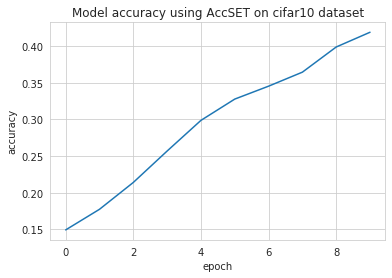

------------END of experiment 'Model accuracy using AccSET' for dataset: cifar10------------
------------START of experiment 'Model accuracy using CenKatzSET' for dataset: cifar10------------
Init mask weight shape:  (3072, 4000)
Create Sparse Matrix: No parameters, NoRows, NoCols  141168.0 3072 4000
Init mask weight shape:  (4000, 1000)
Create Sparse Matrix: No parameters, NoRows, NoCols  100171.0 4000 1000
Init mask weight shape:  (1000, 4000)
Create Sparse Matrix: No parameters, NoRows, NoCols  100685.0 1000 4000
Total noPars:  342024.0
Dataset name:  cifar10
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
sparse_1 (Dense)             (None, 4000)              12292000  
_________________________________________________________________
srelu1 (Activ

KeyboardInterrupt: 

In [52]:
K.clear_session()

print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


datasets=[cifar10, fashion_mnist, cifar10, cifar10] # fashion_mnist (28,28,1) 784-256-128-100-10 , cifar10(32, 32, 3)  3072-4000-1000-4000-10
 
dataset_input_shape=[(32, 32, 3),(28,28,1), (32, 32, 3), (32, 32, 3)]
maxepoches=[50, 50, 100, 100]
layer_sizes = [[4000,1000,4000],[784,256,128,100],[4000,1000,4000],[4000,1000,4000]]
pruning_approachs=["AccSET","AccSET","CenSET","SET"]
centrality_metrics = [None, None, "katz","pagerank"]
experiment_titles = ["Model accuracy using AccSET","Model accuracy using AccSET","Model accuracy using CenPagerankSET","Model accuracy using SET"]

run_experiments(datasets, dataset_input_shape,layer_sizes, maxepoches, pruning_approachs ,experiment_titles, centrality_metrics)

fit_zeta(10, cifar10, [4000,1000,4000], (32, 32, 3), "CenSET", "laplacian", (0, 0.2), 0.005 )



### Tickets
- Improve access speed on sparse adj matrix in W -> N - test using list of list sparse matrices
 
- Allow for changing of metric
- Choose better metrics
- Create framework to find pruning threshold for a metric
- Fix tex saving
- Show MLP in comparison charts ?
- Track number of connections per epoch
- Track number of connections and centraility across network at end of training






